<a href="https://colab.research.google.com/github/RamSaw/image-processing/blob/master/Copy_of_tl_kaggle_hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Классифицируйте dataset с фотографиями дорожных знаков и побейте sample submission в данном соревновании:

https://www.kaggle.com/t/74697eb4f6a3453b9143788e6d5e3de1

Все данные и необходимая разметка лежит по ссылке во вкладке Data.

Задачу надо решить двумя способами, с помощью классического компьютерного зрения и с помощью нейронных сетей. Ваши сабмишшены должны иметь суффикс _classic.csv и _neural.csv

За каждый пункт вы получите от 5ти до 15ти баллов, на результат влияет не только ваш кэггловский скор, но и код и само решение. Код необходимо приложить до дедлайна.

Задание присылать на обе почты почты aleksartamonov@gmail.com dashkov.alexander.om@gmail.com в виде ссылки на colab

В теме письма указать HSE2020 HW3 <Фамилия Имя>

soft deadline: 23.02.2020T23:59:00+0300

hard deadline: 01.03.2020T23:59:00+0300

In [0]:
import numpy as np
import torch
import random
import os
import pandas as pd
import cv2
import matplotlib.pylab as plt
%matplotlib inline
plt.style.use('default')

In [2]:
def make_reproducible(seed, make_cuda_reproducible):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if make_cuda_reproducible:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

SEED = 2341
make_reproducible(SEED, False)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda


Давайте для начала загрузим тренировочные данные

In [3]:
from google.colab import drive
drive.mount('./gdrive')

Drive already mounted at ./gdrive; to attempt to forcibly remount, call drive.mount("./gdrive", force_remount=True).


In [0]:
DRIVE_DATA_ROOT = './gdrive/My Drive/cv2_data'

In [0]:
def show_rgb(img, size=3):
    plt.figure(figsize=(size,size))
    ax = plt.axes([0,0,1,1], frameon=False)
    ax.set_axis_off()
    plt.imshow(img)

In [0]:
def load_data():
  import zipfile

  train_X = []
  train_Y = []
  train_filenames = []
  test_X = []
  test_filenames = []
  print('Loading data...')
  with zipfile.ZipFile(DRIVE_DATA_ROOT + '/data.zip', 'r') as zip_file:
    for filename in zip_file.namelist():
      if filename[-4:] == '.png':
        filename_to_save = filename.split('/')[-1]
        data = zip_file.read(filename)
        img = cv2.imdecode(np.frombuffer(data, np.uint8), cv2.IMREAD_COLOR) 
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if filename.startswith('test'):
          test_X.append(img)
          test_filenames.append(filename_to_save)
        else:
          train_X.append(img)
          train_filenames.append(filename_to_save)
    train_csv_data = pd.read_csv(DRIVE_DATA_ROOT + '/train.csv')
    filename_to_class = {filename: cls for filename, cls in zip(train_csv_data['filename'], train_csv_data['class_number'])}
    train_Y = [filename_to_class[filename] for filename in train_filenames]
  return np.array(train_X), np.array(train_Y), train_filenames, np.array(test_X), test_filenames

In [7]:
X, Y, FILENAMES, TEST_X, TEST_FILENAMES = load_data()

Loading data...


Y 20: 60
filename 20: 000600.png


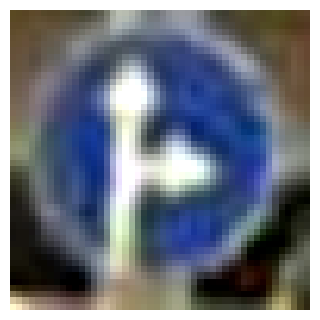

In [8]:
print(f'Y 20: {Y[20]}')
print(f'filename 20: {FILENAMES[20]}')
show_rgb(X[20])

In [0]:
from sklearn.model_selection import train_test_split
TRAIN_X, VAL_X, TRAIN_Y, VAL_Y = train_test_split(X, Y, test_size=0.3, random_state=SEED)

In [10]:
print(f'TRAIN_X: {TRAIN_X.shape}')
print(f'TRAIN_Y: {TRAIN_Y.shape}')
print(f'VAL_X: {VAL_X.shape}')
print(f'VAL_Y: {VAL_Y.shape}')
print(f'TEST_X: {TEST_X.shape}')
print(f'Classes from {TRAIN_Y.min()} to {TRAIN_Y.max()}')

TRAIN_X: (17802, 48, 48, 3)
TRAIN_Y: (17802,)
VAL_X: (7630, 48, 48, 3)
VAL_Y: (7630,)
TEST_X: (7551, 48, 48, 3)
Classes from 0 to 66


TRAIN_Y 20: 27


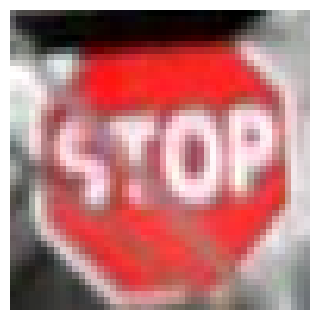

In [11]:
print(f'TRAIN_Y 20: {TRAIN_Y[20]}')
show_rgb(TRAIN_X[20])

VAL_Y 20: 38


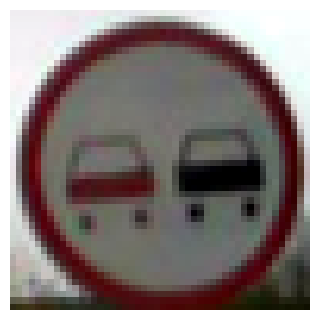

In [12]:
print(f'VAL_Y 20: {VAL_Y[20]}')
show_rgb(VAL_X[20])

TEST 20: 000122.png


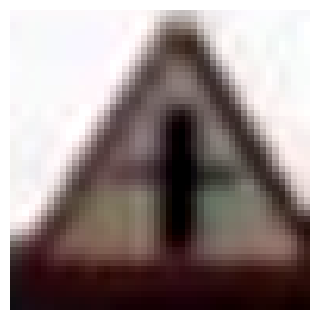

In [13]:
print(f'TEST 20: {TEST_FILENAMES[20]}')
show_rgb(TEST_X[20])

Данные успешно загружены. Теперь давайте научимся генерить ответ на тест.

In [0]:
def generate_test_Y(model, is_neural):
  suffix = '_neural.csv' if is_neural else '_classic.csv'
  filename = 'submission' + suffix
  path = DRIVE_DATA_ROOT + '/' + filename
  test_Y = model.predict(TEST_X)
  pd.DataFrame({'filename': TEST_FILENAMES, 'class_number': test_Y}).to_csv(path, index=False)

In [0]:
class TestModel:
  def predict(self, test_X):
    return np.zeros(test_X.shape[0])

In [0]:
generate_test_Y(TestModel(), is_neural=True)

In [0]:
generate_test_Y(TestModel(), is_neural=False)

# Classic Machine Learning Solution

In [0]:
def create_hog(winSize = (20,20),
               blockSize = (10,10),
               blockStride = (5,5),
               cellSize = (10,10),
               nbins = 9):
  derivAperture = 1
  winSigma = -1.
  histogramNormType = 0
  L2HysThreshold = 0.2
  gammaCorrection = 1
  nlevels = 64
  signedGradients = True

  hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,histogramNormType,L2HysThreshold,gammaCorrection,nlevels,signedGradients)
  return hog

In [0]:
create_hog().compute(TRAIN_X[20]).shape

(729, 1)

In [0]:
class ClassicModel:
  def __init__(self, winSize, blockSize, blockStride, cellSize, nbins, degree):
    from sklearn import svm
    self.hog = create_hog(winSize, blockSize, blockStride, cellSize, nbins)
    self.svm = svm.SVC(decision_function_shape='ovr', kernel='poly', degree=degree)
  
  def extract_features(self, X):
    hog_X = []
    for i in range(len(X)):
      hog_X.append(self.hog.compute(X[i]).reshape(-1))
    return np.array(hog_X)

  def fit(self, X, y):
    X = self.extract_features(X)
    self.svm.fit(X, y)
  
  def predict(self, X):
    X = self.extract_features(X)
    return self.svm.predict(X)
  
  def accuracy(self, X, y):
    return (self.predict(X) == y).sum() / len(y)

In [0]:
CLASSIC_MODEL_1 = ClassicModel(winSize=(20,20), blockSize=(10,10), blockStride=(5,5), cellSize=(10,10), nbins=9, degree=4)

In [0]:
CLASSIC_MODEL_1.fit(TRAIN_X, TRAIN_Y)

In [0]:
print(f'Train acc: {CLASSIC_MODEL_1.accuracy(TRAIN_X, TRAIN_Y)}')

Train acc: 1.0


In [0]:
print(f'Val acc: {CLASSIC_MODEL_1.accuracy(VAL_X, VAL_Y)}')

Val acc: 0.9722149410222805


In [0]:
generate_test_Y(CLASSIC_MODEL_1, is_neural=False)

На kaggle эта модель получила score = 0.88520.

# Deep Learning Solution

In [0]:
from torchvision import datasets, models, transforms
import torch.utils.data as data
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import copy

We will finetune ResNet18 from Pytorch hub.

In [0]:
NUM_CLASSES = Y.max() + 1

In [20]:
print(f'Number of classes: {NUM_CLASSES}')

Number of classes: 67


In [0]:
class TrafficSignsDataset(data.Dataset):
    def __init__(self, X, y, transform):
        self.X = X
        self.y = y
        self.transform = transform
        
    def __getitem__(self, i):
        return self.transform(self.X[i]), torch.LongTensor([self.y[i]])
    
    def __len__(self):
        return len(self.y)

In [0]:
class NeuralModel:
  def __init__(self, num_classes, resnet_type, use_pretrained, freeze_weights, batch_size, lr, epochs):
    self.model = None
    if resnet_type == 'resnet18':
      self.model = models.resnet18(pretrained=use_pretrained)
    if freeze_weights:
      for param in self.model.parameters():
          param.requires_grad = False
    self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
    self.model.to(DEVICE)
    self.criterion = nn.CrossEntropyLoss()
    self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
    self.data_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(
            size=(224, 224)
        ),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])
    self.batch_size = batch_size
    self.epochs = epochs

  def fit(self, train_X, train_Y, val_X, val_Y):
    train_dataset = TrafficSignsDataset(train_X, train_Y, self.data_transform)
    val_dataset = TrafficSignsDataset(val_X, val_Y, self.data_transform)
    dataloaders = {
        'train': data.DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=4),
        'val': data.DataLoader(val_dataset, batch_size=self.batch_size, shuffle=True, num_workers=4),
    }
    dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}
    self.train(dataloaders, dataset_sizes)
  
  def train(self, dataloaders, dataset_sizes):
    best_model_weights = copy.deepcopy(self.model.state_dict())
    best_acc = 0.0

    for epoch in range(1, self.epochs + 1):
        print(f'Epoch {epoch} / {self.epochs}')
        
        for phase in ['train', 'val']:
            if phase == 'train':
                self.model.train()
            else:
                self.model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(DEVICE)
                labels = labels.squeeze(-1).to(DEVICE)

                self.optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = self.model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = self.criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        self.optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double().item() / dataset_sizes[phase]

            print(f'{phase} Loss: {round(epoch_loss, 4)} Acc: {round(epoch_acc, 4)}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_weights = copy.deepcopy(self.model.state_dict())
        print()

    print(f'Best val Acc: {round(best_acc, 4)}'.format())

    self.model.load_state_dict(best_model_weights)
  
  def predict(self, X):
    dataset = TrafficSignsDataset(X, np.zeros(X.shape[0]), self.data_transform)
    dataloader = data.DataLoader(dataset, batch_size=self.batch_size, shuffle=False, num_workers=4)
    self.model.eval()
    y = []
    with torch.no_grad():
      for inputs, _ in dataloader:
          inputs = inputs.to(DEVICE)
          outputs = self.model(inputs)
          _, preds = torch.max(outputs, 1)
          y += [preds[i].item() for i in range(len(preds))]
    return np.array(y)
  
  def accuracy(self, X, y):
    return (self.predict(X) == y).sum() / len(y)

In [0]:
def train_neural_model(model):
  print(f'Initial train acc: {model.accuracy(TRAIN_X, TRAIN_Y)}')
  print(f'Initial val acc: {model.accuracy(VAL_X, VAL_Y)}')
  model.fit(TRAIN_X, TRAIN_Y, VAL_X, VAL_Y)

In [0]:
NEURAL_MODEL_1 = NeuralModel(NUM_CLASSES, 'resnet18', use_pretrained=True, freeze_weights=False, batch_size=128, lr=1e-3, epochs=25)

In [31]:
train_neural_model(NEURAL_MODEL_1)

Initial train acc: 0.01876193686102685
Initial val acc: 0.0163826998689384
Epoch 1 / 25
train Loss: 0.426 Acc: 0.8991
val Loss: 0.1697 Acc: 0.9545

Epoch 2 / 25
train Loss: 0.0829 Acc: 0.9774
val Loss: 0.0938 Acc: 0.9761

Epoch 3 / 25
train Loss: 0.0471 Acc: 0.9875
val Loss: 0.1426 Acc: 0.9596

Epoch 4 / 25
train Loss: 0.0493 Acc: 0.9867
val Loss: 0.0696 Acc: 0.981

Epoch 5 / 25
train Loss: 0.0319 Acc: 0.9922
val Loss: 0.0546 Acc: 0.9858

Epoch 6 / 25
train Loss: 0.0195 Acc: 0.9949
val Loss: 0.0488 Acc: 0.9875

Epoch 7 / 25
train Loss: 0.0242 Acc: 0.9942
val Loss: 0.0401 Acc: 0.9899

Epoch 8 / 25
train Loss: 0.0098 Acc: 0.9978
val Loss: 0.0624 Acc: 0.983

Epoch 9 / 25
train Loss: 0.0065 Acc: 0.9984
val Loss: 0.0476 Acc: 0.9877

Epoch 10 / 25
train Loss: 0.0099 Acc: 0.9976
val Loss: 0.0611 Acc: 0.9845

Epoch 11 / 25
train Loss: 0.0331 Acc: 0.9918
val Loss: 0.112 Acc: 0.972

Epoch 12 / 25
train Loss: 0.0236 Acc: 0.9934
val Loss: 0.0827 Acc: 0.9786

Epoch 13 / 25
train Loss: 0.0122 Acc: 0

In [0]:
generate_test_Y(NEURAL_MODEL_1, is_neural=True)

На kaggle эта модель получила score = 0.98057.